## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.
- It is required to obtain <b>ROC > 0.65</b>.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

### Create a spark session and import the required libraries

In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession 

In [3]:
spark = SparkSession.builder.appName("Final Exam").getOrCreate()

### Create a data schema programatically

In [4]:
schema = "id INT, gender STRING, age DOUBLE, hypertension INT, heart_disease INT, ever_married STRING ,work_type STRING, Residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING, stroke INT "

### Read the data using the standard DataReader (Key,Value) pairs format
- Provide the schema and any other required options.

In [5]:
data='healthcare-dataset-stroke-data.csv'

df=(spark.read.format('csv')
    .schema(schema)
    .option('header','true')
    .load(data)
)

In [6]:
df.count()

5110

### Explore the data 
#### You have to do the following:
- Print the Schema.
- Show the first 10 rows from the data.
- Explore null values and show how many null values in each column.
- Plot a count plot for the target label and <b>notice the graph</b>.
- Perform any additional EDA you find useful.

In [7]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [8]:
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [9]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [10]:
import matplotlib.pyplot as plt

+------+-----+
|stroke|count|
+------+-----+
|     1|  249|
|     0| 4861|
+------+-----+



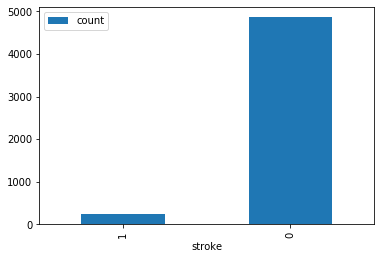

In [11]:
df1=df.groupby('stroke').count()
df1.show()

df_pandas = df1.toPandas()
df_pandas.plot(kind='bar', x='stroke', y='count')
plt.show()

### Get the summary statistics of the age column
- You will find the minimum age is about <b>0.08</b>.
- Remove rows for the age below <b>2 years old</b>.

In [12]:
from pyspark.sql.functions import min as _min
from pyspark.sql.functions import col

minimum_age = df.select(_min(col('age')).alias('min_age')).collect()
print(minimum_age)

[Row(min_age=0.08)]


In [13]:
df.describe('age').show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



In [14]:
df=df.filter("age>=2")

### Working with gender & smoking_status columns:
- Select and show the gender & smoking_status columns
- Get the distinct values for each column.

In [15]:
df.createOrReplaceTempView("table")

In [16]:
spark.sql("""SELECT gender,smoking_status FROM table""").show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [17]:
spark.sql("""SELECT DISTINCT gender FROM table """).show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [18]:
spark.sql("""SELECT DISTINCT smoking_status FROM table """).show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



#### Change the string values of the columns into numerical values as follow:
1. Gender column:
    * Male = 1 
    * Female = 0 
    * Other = 0 
2. Smoking Status column:
  * never smoked = 0
  * Unknown = 0.5
  * formerly smoked = 0.75
  * smokes = 1.0


In [19]:
df=df.replace(['Male', 'Female','Other'], ['1','0','0'], 'gender')
df=df.replace(['never smoked', 'Unknown','formerly smoked','smokes'], ['0','0.5','0.75','1.0'], 'smoking_status')
df=df.withColumn("gender",df.gender.cast('int'))
df=df.withColumn("smoking_status",df.smoking_status.cast('double'))

#### Show the output DataFrame
- Select and show the gender & smoking_status columns after value changing.
- Print schema for the new dataframe.

In [20]:
df.createOrReplaceTempView("New_table")

In [21]:
spark.sql("""SELECT gender,smoking_status FROM New_table""").show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



### Deal with null value according to your data analysis.

In [22]:
df.count()

4990

In [23]:
df=df.na.drop()

In [24]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()
# So it appeares that there is no null data in any columns in our data

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [25]:
df.count()

4795

### Split the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.
- Save each dataframe as a parquet file

In [26]:
train_df, test_df = df.randomSplit([0.8,0.2],seed=42)

In [28]:
train_df.write.parquet("output/train_df.parquet")

In [29]:
test_df.write.parquet("output2/test_df.parquet")

### Read the saved Train and Test DataFrame:
- Use the dataframes you read in the subsequent steps.

In [30]:
train_file='output/train_df.parquet'

train=spark.read.format("parquet").load(train_file)
train.count()

3877

In [31]:
test_file='output2/test_df.parquet'

test=spark.read.format("parquet").load(test_file)
test.count()

918

### Create the model:
- Perform feature engineering steps.
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

In [32]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression

In [33]:
categoricalColumns = [col for (col, dtype) in train.dtypes
                   if dtype == "string"]
categoricalColumns 

['ever_married', 'work_type', 'Residence_type']

In [34]:
indexOutputColumns = [x + "_Index" for x in categoricalColumns]
indexOutputColumns

['ever_married_Index', 'work_type_Index', 'Residence_type_Index']

In [35]:
oheOutputColumns = [x + "_OHE" for x in categoricalColumns]
oheOutputColumns

['ever_married_OHE', 'work_type_OHE', 'Residence_type_OHE']

In [36]:
stringIndexer = StringIndexer(inputCols=categoricalColumns,
                             outputCols=indexOutputColumns,
                             handleInvalid='skip')
oheEncoder = OneHotEncoder(inputCols=indexOutputColumns,
                          outputCols=oheOutputColumns)

In [37]:
numericColumns = [field for (field,dataType) in train.dtypes
              if ((dataType=='double'or dataType=='int'))]
numericColumns.remove('stroke')
numericColumns.remove('id')

numericColumns

['gender',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'smoking_status']

In [38]:
assemblerInputs = oheOutputColumns + numericColumns
assemblerInputs

['ever_married_OHE',
 'work_type_OHE',
 'Residence_type_OHE',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'smoking_status']

In [39]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=assemblerInputs,outputCol='features')

In [40]:
lr = LogisticRegression(featuresCol='features', labelCol='stroke', predictionCol='prediction')
pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr])

In [41]:
pipelineModel = pipeline.fit(train)

### Perform predictions on tests dataframe:
- Test the model using the test dataframe
- Select and show the feature column.
- Print the schema of the output dataframe.
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   

In [42]:
predDF = pipelineModel.transform(test)

In [43]:
predDF.select('features').show(truncate=False)
predDF.createOrReplaceTempView("ntable")

+-----------------------------------------------------------+
|features                                                   |
+-----------------------------------------------------------+
|(13,[1,5,7,10,11],[1.0,1.0,42.0,98.53,18.5])               |
|(13,[1,7,10,11,12],[1.0,20.0,94.67,28.8,0.5])              |
|(13,[0,1,7,10,11,12],[1.0,1.0,43.0,88.23,37.6,0.5])        |
|(13,[0,1,5,6,7,10,11],[1.0,1.0,1.0,1.0,79.0,198.79,24.9])  |
|(13,[0,1,5,7,10,11,12],[1.0,1.0,1.0,58.0,105.74,26.8,0.75])|
|(13,[0,3,5,7,10,11,12],[1.0,1.0,1.0,37.0,72.09,24.1,1.0])  |
|(13,[4,7,10,11,12],[1.0,3.0,94.12,21.4,0.5])               |
|(13,[4,7,10,11,12],[1.0,14.0,92.22,22.8,0.5])              |
|(13,[3,7,10,11],[1.0,39.0,87.33,34.3])                     |
|(13,[4,7,10,11,12],[1.0,5.0,75.1,20.7,0.5])                |
|(13,[0,2,5,7,10,11,12],[1.0,1.0,1.0,74.0,68.18,27.3,0.75]) |
|(13,[1,7,10,11],[1.0,16.0,87.54,37.8])                     |
|(13,[0,1,5,6,7,10,11],[1.0,1.0,1.0,1.0,34.0,83.75,37.0])   |
|(13,[4,

In [44]:
predDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- ever_married_Index: double (nullable = false)
 |-- work_type_Index: double (nullable = false)
 |-- Residence_type_Index: double (nullable = false)
 |-- ever_married_OHE: vector (nullable = true)
 |-- work_type_OHE: vector (nullable = true)
 |-- Residence_type_OHE: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [45]:
predDF.select('prediction','stroke').show(truncate=False)

+----------+------+
|prediction|stroke|
+----------+------+
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |1     |
|0.0       |0     |
|0.0       |0     |
|0.0       |0     |
|0.0       |1     |
+----------+------+
only showing top 20 rows



In [46]:
spark.sql("""SELECT prediction, stroke
          FROM ntable 
          WHERE stroke ==1
        """).show(truncate=False)

+----------+------+
|prediction|stroke|
+----------+------+
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
|0.0       |1     |
+----------+------+
only showing top 20 rows



In [47]:
df2=predDF.groupby('stroke').count()
df2.show()

+------+-----+
|stroke|count|
+------+-----+
|     1|   37|
|     0|  881|
+------+-----+



### Evaluate the model performance
- Use <b>BinaryClassificationEvaluator</b>. This will calculate the <b>ROC</b>.
- Set the parameters as follow:
    - <b>rawPredictionCol='prediction'</b> and <b>labelCol='stroke'</b>

In [48]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [49]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [50]:
evaluatorROC.evaluate(predDF)

0.5

### Improve Model Performance
- You may noticed that <b>the target label is imbalanced</b>.
- LogisticRegression classifier has a special parameter <b>weightCol</b> to deal with imbalanced class.
- In order to use this parameter you must have a <b>weightCol</b> in your training dataframe.
- In order to create this column you will need to define a <b>UDF</b> and apply it to the target label column.
- Create a LogisticRegression classifier with <b>weightCol</b> parameter.
- Build and train a pipeline model with the new LogisticRegression.
- Perform the prediction on the test dataframe. 
- Select and show both prediction and label columns.
- Explore the results for the label column stroke=1. i.e. select both columns (prediction,stroke) for stroke=1.<b>notice the result.</b> 
- Count the predicted 1 and 0 values.<b>notice the result.</b>   
- Evaluate the model performance exactly as in the previous step.

In [51]:
from pyspark.sql.functions import udf

In [52]:
stroke_0=train.select('stroke').where(col('stroke')==0).count()

In [53]:
stroke_1=train.select('stroke').where(col('stroke')==1).count()

In [54]:
total=train.select('stroke').count()

In [65]:
prob_stroke_1=stroke_1/total
prob_stroke_0=stroke_0/total

In [56]:
# creating a UDF
def weightedcol(x):
    if x==0:
        return 1-prob_stroke_0
    else:
        return 1-prob_stroke_1

In [57]:
convertUDF = udf(lambda z: weightedcol(z))

In [58]:
train=train.withColumn('weightCol',convertUDF(col('stroke')))

In [59]:
trainDF=train.withColumn("weightCol", train["weightCol"].cast('double'))

In [60]:
lr2 = LogisticRegression(featuresCol='features', labelCol='stroke',weightCol='weightCol')
pipeline =Pipeline(stages = [stringIndexer,oheEncoder,vecAssembler,lr2])

In [61]:
trainDF.select('weightCol').show()

+-------------------+
|          weightCol|
+-------------------+
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
| 0.9556358008769668|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
|0.04436419912303324|
+-------------------+
only showing top 20 rows



In [62]:
pipeModel = pipeline.fit(trainDF)

In [63]:
pred_new = pipeModel.transform(test)

In [64]:
evaluatorROC.evaluate(pred_new)

0.8249532165536706